# PHYC 4250: Topics in numerical programming Problem set 3 
Yi Ming Chang <br>
B00751897<br>
Mar. 11th, 2021

# Question 1: DNN regression

## Part 1 a) b) c)

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import sys, os, argparse
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
seed=0
np.random.seed(seed) # fix random seed
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# For next cell
from sklearn.metrics import roc_auc_score
import time
import xgboost as xgb
import warnings

#import ml_style as style
import matplotlib as mpl


## Step 1: Load and Process the Data and test importance of features by XGBoost on three datasets (math, portuguese, math and portuguese)

### I include all of the features in my dataset first copy the code from NB 10 where use XGBoost to determine the importance of features. I use 'pip install xgboost' to fix the problem of running XGBoost. I have test the importance of features on three datasets (math, portuguese, math and portuguese). So that I would know what features to include prediction is more significant.

In [2]:
def load_dataset(training_ratio,file):
    root_dir=r'C://Users//Yi Ming Chang//Desktop//Dal//PHYC 4250 Topics in Numerical Computing//Problem Sets//Problem set 3'
    
    # read the files
    if file == 'math':
        df = pd.read_csv(root_dir+'//student-mat.csv',delimiter=';')
    elif file == 'por':
        df = pd.read_csv(root_dir+'//student-por.csv',delimiter=';')
    else:
        dfA = pd.read_csv(root_dir+'//student-mat.csv',delimiter=';')
        dfB = pd.read_csv(root_dir+'//student-por.csv',delimiter=';')
        df = pd.concat([dfA,dfB])
    
    #select features #   if col!='age' if col!='Pstatus' if col!= 'Medu' if col!= 'Fedu' if col!= 'reason'if col!= 'traveltime' if col!='studytime'  if col!='failures' if col!='schoolsup' if col!= 'famsup' if col!= 'paid' if col!= 'activities' if col!='nursery' if col!= 'higher' if col!= 'internet' if col!= 'romantic'if col!= 'absences' if col!= 'famrel' if col!= 'freetime' if col!= 'goout' if col!= 'Dalc' if col!= 'Walc' if col!= 'health'if col!='school' if col!='address' if col!='guardian'  if col!= 'Mjob' if col!='Fjob'  if col!= 'sex' if col!='famsize' 
    features = [col for col in df.columns if col!='G3']

    # Convert all of the string/words into numerical values in order to use them in prediction
    df['school'] = df['school'].map({ 'GP': 0 , 'MS' : 1})
    df['sex'] = df['sex'].map({ 'F': 0 , 'M' : 1})
    df['address'] = df['address'].map({ 'U': 0 , 'R' : 1})
    df['famsize'] = df['famsize'].map({ 'LE3': 0 , 'GT3' : 1})
    df['Pstatus'] = df['Pstatus'].map({ 'T': 0 , 'A' : 1})
    df['Mjob'] = df['Mjob'].map({ 'teacher': 0 , 'health' : 1, 'services':2,'at_home':3,'other':4})
    df['Fjob'] = df['Fjob'].map({ 'teacher': 0 , 'health' : 1, 'services':2,'at_home':3,'other':4})
    df['reason'] = df['reason'].map({ 'home': 0 , 'reputation' : 1, 'course':2,'other':3})
    df['guardian'] = df['guardian'].map({ 'mother': 0 , 'father' : 1,'other':2})
    df['schoolsup'] = df['schoolsup'].map({ 'yes': 0 , 'no' : 1})
    df['famsup'] = df['famsup'].map({ 'yes': 0 , 'no' : 1})
    df['paid'] = df['paid'].map({ 'yes': 0 , 'no' : 1})
    df['activities'] = df['activities'].map({ 'yes': 0 , 'no' : 1})
    df['nursery'] = df['nursery'].map({ 'yes': 0 , 'no' : 1})
    df['higher'] = df['higher'].map({ 'yes': 0 , 'no' : 1})
    df['internet'] = df['internet'].map({ 'yes': 0 , 'no' : 1})
    df['romantic'] = df['romantic'].map({ 'yes': 0 , 'no' : 1})

    # set y dataset as student final grade, and X is a matrix with n dimension (n features) 
    y = df['G3'].values
    X = df[features] #select the column that we want only
    #X = X.values #exclude the first rows, which are strings
    
    # generate X_train, Y_train, X_test,Y_test data
    # Or could also use train_test_split(X,y,test_ratio=1-training_ratio,random_state=0) to shuffle and generate datasets
    Range = int(training_ratio*len(X))
    Range1 = int(training_ratio*len(y))
    X_train = X[0:Range]
    X_test = X[Range:]
    Y_train = y[:Range1]
    Y_test = y[Range1:]

    # print the size of datasets
    print('x_train shape:', X_train.shape)
    print('x_test shape:', X_test.shape)
    print('y_train shape:', Y_train.shape)
    print('y_test shape:', Y_test.shape)
    

    return df,X,X_train,X_test,Y_train,Y_test

In [3]:
df,X,X_train,X_test,Y_train,Y_test = load_dataset(0.8,'math')
df

x_train shape: (316, 32)
x_test shape: (79, 32)
y_train shape: (316,)
y_test shape: (79,)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,0,1,1,4,4,3,0,...,4,3,4,1,1,3,6,5,6,6
1,0,0,17,0,1,0,1,1,3,4,...,5,3,3,1,1,3,4,5,5,6
2,0,0,15,0,0,0,1,1,3,4,...,4,3,2,2,3,3,10,7,8,10
3,0,0,15,0,1,0,4,2,1,2,...,3,2,2,1,1,5,2,15,14,15
4,0,0,16,0,1,0,3,3,4,4,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,1,20,0,0,1,2,2,2,2,...,5,5,4,4,5,4,11,9,9,9
391,1,1,17,0,0,0,3,1,2,2,...,2,4,5,3,4,2,3,14,16,16
392,1,1,21,1,1,0,1,1,4,4,...,5,5,3,3,3,3,3,10,8,7
393,1,1,18,1,0,0,3,2,2,4,...,4,4,1,3,4,5,0,11,12,10


Training on 316 examples with 32 features
[23:44:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Yi Ming Chang\anaconda3\envs\Tensflow\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Predicting on 79 examples with 32 features

Model Accuracy with all features: 45.57%
Run time with all features: 4.36 sec




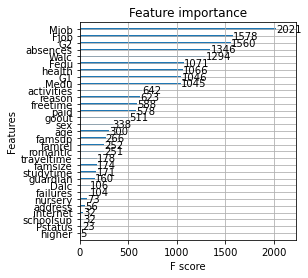

In [625]:
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

print("Training on %i examples with %i features"%X_train.shape)

#Use default parameters and train on full dataset
XGBclassifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=1, n_estimators=1000)
#Train and time classifier
start_time = time.time()
XGBclassifier.fit(X_train, Y_train)
run_time = time.time() - start_time

#Make Predictions
print("Predicting on %i examples with %i features\n"%X_test.shape)
y_pred= XGBclassifier.predict(X_test)

#Print Results
print("Model Accuracy with all features: {:.2f}%".format(100*XGBclassifier.score(X_test, Y_test)))
print("Run time with all features: {:.2f} sec\n\n".format(run_time))


%matplotlib inline  

fig=plt.figure()
xgb.plot_importance(XGBclassifier, ax=plt.gca())
fig.subplots_adjust(left=0.4)  #
fig.savefig('SUSYXGBoost1.pdf')

## It seems like the features of 'school', 'higher', 'Pstatus', 'schoolsup', 'address', 'internet', 'nursery', 'failures', and 'Dalc' are not significant to our math dataset, so I am going to leave them out of the prediction

In [611]:
def load_dataset(training_ratio,file):
    root_dir=r'C://Users//Yi Ming Chang//Desktop//Dal//PHYC 4250 Topics in Numerical Computing//Problem Sets//Problem set 3'
    
    # read the files
    if file == 'math':
        df = pd.read_csv(root_dir+'//student-mat.csv',delimiter=';')
    elif file == 'por':
        df = pd.read_csv(root_dir+'//student-por.csv',delimiter=';')
    else:
        dfA = pd.read_csv(root_dir+'//student-mat.csv',delimiter=';')
        dfB = pd.read_csv(root_dir+'//student-por.csv',delimiter=';')
        df = pd.concat([dfA,dfB])
    
    #select features #   if col!='age' if col!='Pstatus' if col!= 'Medu' if col!= 'Fedu' if col!= 'reason'if col!= 'traveltime' if col!='studytime'  if col!='failures' if col!='schoolsup' if col!= 'famsup' if col!= 'paid' if col!= 'activities' if col!='nursery' if col!= 'higher' if col!= 'internet' if col!= 'romantic'if col!= 'absences' if col!= 'famrel' if col!= 'freetime' if col!= 'goout' if col!= 'Dalc' if col!= 'Walc' if col!= 'health'if col!='school' if col!='address' if col!='guardian'  if col!= 'Mjob' if col!='Fjob'  if col!= 'sex' if col!='famsize' 
    features = [col for col in df.columns if col!='G3']

    # Convert all of the string/words into numerical values in order to use them in prediction
    df['school'] = df['school'].map({ 'GP': 0 , 'MS' : 1})
    df['sex'] = df['sex'].map({ 'F': 0 , 'M' : 1})
    df['address'] = df['address'].map({ 'U': 0 , 'R' : 1})
    df['famsize'] = df['famsize'].map({ 'LE3': 0 , 'GT3' : 1})
    df['Pstatus'] = df['Pstatus'].map({ 'T': 0 , 'A' : 1})
    df['Mjob'] = df['Mjob'].map({ 'teacher': 0 , 'health' : 1, 'services':2,'at_home':3,'other':4})
    df['Fjob'] = df['Fjob'].map({ 'teacher': 0 , 'health' : 1, 'services':2,'at_home':3,'other':4})
    df['reason'] = df['reason'].map({ 'home': 0 , 'reputation' : 1, 'course':2,'other':3})
    df['guardian'] = df['guardian'].map({ 'mother': 0 , 'father' : 1,'other':2})
    df['schoolsup'] = df['schoolsup'].map({ 'yes': 0 , 'no' : 1})
    df['famsup'] = df['famsup'].map({ 'yes': 0 , 'no' : 1})
    df['paid'] = df['paid'].map({ 'yes': 0 , 'no' : 1})
    df['activities'] = df['activities'].map({ 'yes': 0 , 'no' : 1})
    df['nursery'] = df['nursery'].map({ 'yes': 0 , 'no' : 1})
    df['higher'] = df['higher'].map({ 'yes': 0 , 'no' : 1})
    df['internet'] = df['internet'].map({ 'yes': 0 , 'no' : 1})
    df['romantic'] = df['romantic'].map({ 'yes': 0 , 'no' : 1})

    # set y dataset as student final grade, and X is a matrix with n dimension (n features) 
    y = df['G3'].values
    X = df[features] #select the column that we want only
    #X = X.values #exclude the first rows, which are strings
    
    # generate X_train, Y_train, X_test,Y_test data
    # Or could also use train_test_split(X,y,test_ratio=1-training_ratio,random_state=0) to shuffle and generate datasets
    Range = int(training_ratio*len(X))
    Range1 = int(training_ratio*len(y))
    X_train = X[0:Range]
    X_test = X[Range:]
    Y_train = y[:Range1]
    Y_test = y[Range1:]

    # print the size of datasets
    print('x_train shape:', X_train.shape)
    print('x_test shape:', X_test.shape)
    print('y_train shape:', Y_train.shape)
    print('y_test shape:', Y_test.shape)
    

    return df,X,X_train,X_test,Y_train,Y_test

In [612]:
df,X,X_train,X_test,Y_train,Y_test = load_dataset(0.8,'por')

x_train shape: (519, 32)
x_test shape: (130, 32)
y_train shape: (519,)
y_test shape: (130,)


Training on 519 examples with 32 features
[21:05:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Yi Ming Chang\anaconda3\envs\Tensflow\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Predicting on 130 examples with 32 features

Model Accuracy with all features: 30.77%
Run time with all features: 4.47 sec




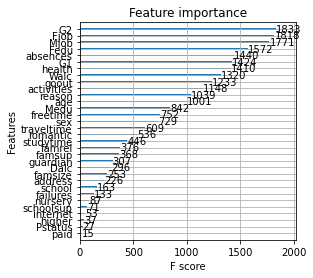

In [157]:
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

print("Training on %i examples with %i features"%X_train.shape)

#Use default parameters and train on full dataset
XGBclassifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=1, n_estimators=1000)
#Train and time classifier
start_time = time.time()
XGBclassifier.fit(X_train, Y_train)
run_time = time.time() - start_time

#Make Predictions
print("Predicting on %i examples with %i features\n"%X_test.shape)
y_pred= XGBclassifier.predict(X_test)

#Print Results
print("Model Accuracy with all features: {:.2f}%".format(100*XGBclassifier.score(X_test, Y_test)))
print("Run time with all features: {:.2f} sec\n\n".format(run_time))

%matplotlib inline  

fig=plt.figure()
xgb.plot_importance(XGBclassifier, ax=plt.gca())
fig.subplots_adjust(left=0.4)  #
fig.savefig('SUSYXGBoost1.pdf')

## It seems like the features of 'paid', 'Pstatus', 'schoolsup', 'higher', 'internet', 'nursery', 'failures' and 'school' are not significant to our math dataset, so I am going to leave them out of the prediction

In [158]:
def load_dataset(training_ratio,file):
    root_dir=r'C://Users//Yi Ming Chang//Desktop//Dal//PHYC 4250 Topics in Numerical Computing//Problem Sets//Problem set 3'
    
    # read the files
    if file == 'math':
        df = pd.read_csv(root_dir+'//student-mat.csv',delimiter=';')
    elif file == 'por':
        df = pd.read_csv(root_dir+'//student-por.csv',delimiter=';')
    else:
        dfA = pd.read_csv(root_dir+'//student-mat.csv',delimiter=';')
        dfB = pd.read_csv(root_dir+'//student-por.csv',delimiter=';')
        df = pd.concat([dfA,dfB])
    
    #select features #   if col!='age' if col!='Pstatus' if col!= 'Medu' if col!= 'Fedu' if col!= 'reason'if col!= 'traveltime' if col!='studytime'  if col!='failures' if col!='schoolsup' if col!= 'famsup' if col!= 'paid' if col!= 'activities' if col!='nursery' if col!= 'higher' if col!= 'internet' if col!= 'romantic'if col!= 'absences' if col!= 'famrel' if col!= 'freetime' if col!= 'goout' if col!= 'Dalc' if col!= 'Walc' if col!= 'health'if col!='school' if col!='address' if col!='guardian'  if col!= 'Mjob' if col!='Fjob'  if col!= 'sex' if col!='famsize' 
    features = [col for col in df.columns if col!='G3']

    # Convert all of the string/words into numerical values in order to use them in prediction
    df['school'] = df['school'].map({ 'GP': 0 , 'MS' : 1})
    df['sex'] = df['sex'].map({ 'F': 0 , 'M' : 1})
    df['address'] = df['address'].map({ 'U': 0 , 'R' : 1})
    df['famsize'] = df['famsize'].map({ 'LE3': 0 , 'GT3' : 1})
    df['Pstatus'] = df['Pstatus'].map({ 'T': 0 , 'A' : 1})
    df['Mjob'] = df['Mjob'].map({ 'teacher': 0 , 'health' : 1, 'services':2,'at_home':3,'other':4})
    df['Fjob'] = df['Fjob'].map({ 'teacher': 0 , 'health' : 1, 'services':2,'at_home':3,'other':4})
    df['reason'] = df['reason'].map({ 'home': 0 , 'reputation' : 1, 'course':2,'other':3})
    df['guardian'] = df['guardian'].map({ 'mother': 0 , 'father' : 1,'other':2})
    df['schoolsup'] = df['schoolsup'].map({ 'yes': 0 , 'no' : 1})
    df['famsup'] = df['famsup'].map({ 'yes': 0 , 'no' : 1})
    df['paid'] = df['paid'].map({ 'yes': 0 , 'no' : 1})
    df['activities'] = df['activities'].map({ 'yes': 0 , 'no' : 1})
    df['nursery'] = df['nursery'].map({ 'yes': 0 , 'no' : 1})
    df['higher'] = df['higher'].map({ 'yes': 0 , 'no' : 1})
    df['internet'] = df['internet'].map({ 'yes': 0 , 'no' : 1})
    df['romantic'] = df['romantic'].map({ 'yes': 0 , 'no' : 1})

    # set y dataset as student final grade, and X is a matrix with n dimension (n features) 
    y = df['G3'].values
    X = df[features] #select the column that we want only
    #X = X.values #exclude the first rows, which are strings
    
    # generate X_train, Y_train, X_test,Y_test data
    # Or could also use train_test_split(X,y,test_ratio=1-training_ratio,random_state=0) to shuffle and generate datasets
    Range = int(training_ratio*len(X))
    Range1 = int(training_ratio*len(y))
    X_train = X[0:Range]
    X_test = X[Range:]
    Y_train = y[:Range1]
    Y_test = y[Range1:]

    # print the size of datasets
    print('x_train shape:', X_train.shape)
    print('x_test shape:', X_test.shape)
    print('y_train shape:', Y_train.shape)
    print('y_test shape:', Y_test.shape)
    

    return df,X,X_train,X_test,Y_train,Y_test

In [159]:
df,X,X_train,X_test,Y_train,Y_test = load_dataset(0.8,'mathandpor')

x_train shape: (835, 32)
x_test shape: (209, 32)
y_train shape: (835,)
y_test shape: (209,)


Training on 835 examples with 32 features
[21:05:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Yi Ming Chang\anaconda3\envs\Tensflow\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Predicting on 209 examples with 32 features

Model Accuracy with all features: 39.23%
Run time with all features: 6.64 sec




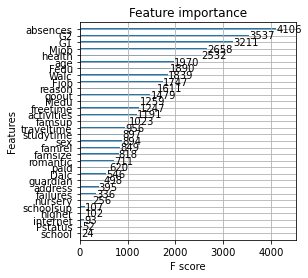

In [160]:
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

print("Training on %i examples with %i features"%X_train.shape)

#Use default parameters and train on full dataset
XGBclassifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=1, n_estimators=1000)
#Train and time classifier
start_time = time.time()
XGBclassifier.fit(X_train, Y_train)
run_time = time.time() - start_time

#Make Predictions
print("Predicting on %i examples with %i features\n"%X_test.shape)
y_pred= XGBclassifier.predict(X_test)

#Print Results
print("Model Accuracy with all features: {:.2f}%".format(100*XGBclassifier.score(X_test, Y_test)))
print("Run time with all features: {:.2f} sec\n\n".format(run_time))


%matplotlib inline  

fig=plt.figure()
xgb.plot_importance(XGBclassifier, ax=plt.gca())
fig.subplots_adjust(left=0.4)  #
fig.savefig('SUSYXGBoost1.pdf')

## It seems like the features of 'school', 'Pstatus', 'internet', 'higher', 'schoolsup','nursery', and 'failure' are not significant to our math dataset, so I am going to leave them out of the prediction

# Reload and Process the Data for Math

In [626]:
def load_dataset(training_ratio,file):
    root_dir=r'C://Users//Yi Ming Chang//Desktop//Dal//PHYC 4250 Topics in Numerical Computing//Problem Sets//Problem set 3'
    
    # read the different files 
    if file == 'math':
        df = pd.read_csv(root_dir+'//student-mat.csv',delimiter=';')
    elif file == 'por':
        df = pd.read_csv(root_dir+'//student-por.csv',delimiter=';')
    else:
        dfA = pd.read_csv(root_dir+'//student-mat.csv',delimiter=';')
        dfB = pd.read_csv(root_dir+'//student-por.csv',delimiter=';')
        df = pd.concat([dfA,dfB])
    
    #select features for different files
    # if col!='age' if col!='Pstatus' if col!= 'Medu' if col!= 'Fedu' if col!= 'reason'if col!= 'traveltime' if col!='studytime'  if col!='failures' if col!='schoolsup' if col!= 'famsup' if col!= 'paid' if col!= 'activities' if col!='nursery' if col!= 'higher' if col!= 'internet' if col!= 'romantic'if col!= 'absences' if col!= 'famrel' if col!= 'freetime' if col!= 'goout' if col!= 'Dalc' if col!= 'Walc' if col!= 'health'if col!='school' if col!='address' if col!='guardian'  if col!= 'Mjob' if col!='Fjob'  if col!= 'sex' if col!='famsiz
    if file == 'math':
        features = [col for col in df.columns if col!='school' if col!='higher' if col!='Pstatus' if col!='schoolsup' if col!='address' if col!='internet' if col!='nursery' if col!='failures' if col!='Dalc' if col!='G3']
    elif file == 'por':
        features = [col for col in df.columns if col!='paid' if col!= 'Pstatus' if col!='schoolsup'if col!= 'higher'if col!= 'internet' if col!='nursery'if col!= 'failures' if col!='school' if col!='G3']
    elif file == 'mathandpor':
        features = [col for col in df.columns if col!='school' if col!='Pstatus'if col!= 'internet' if col!='higher' if col!= 'schoolsup'if col!='nursery' if col!='failure' if col!='G3']
    else:
        features = [col for col in df.columns if col!= 'G3' if col!= 'school']
           
    
    # Convert all of the string/words into numerical values in order to use them in prediction
    df['school'] = df['school'].map({ 'GP': 0 , 'MS' : 1})
    df['sex'] = df['sex'].map({ 'F': 0 , 'M' : 1})
    df['address'] = df['address'].map({ 'U': 0 , 'R' : 1})
    df['famsize'] = df['famsize'].map({ 'LE3': 0 , 'GT3' : 1})
    df['Pstatus'] = df['Pstatus'].map({ 'T': 0 , 'A' : 1})
    df['Mjob'] = df['Mjob'].map({ 'teacher': 0 , 'health' : 1, 'services':2,'at_home':3,'other':4})
    df['Fjob'] = df['Fjob'].map({ 'teacher': 0 , 'health' : 1, 'services':2,'at_home':3,'other':4})
    df['reason'] = df['reason'].map({ 'home': 0 , 'reputation' : 1, 'course':2,'other':3})
    df['guardian'] = df['guardian'].map({ 'mother': 0 , 'father' : 1,'other':2})
    df['schoolsup'] = df['schoolsup'].map({ 'yes': 0 , 'no' : 1})
    df['famsup'] = df['famsup'].map({ 'yes': 0 , 'no' : 1})
    df['paid'] = df['paid'].map({ 'yes': 0 , 'no' : 1})
    df['activities'] = df['activities'].map({ 'yes': 0 , 'no' : 1})
    df['nursery'] = df['nursery'].map({ 'yes': 0 , 'no' : 1})
    df['higher'] = df['higher'].map({ 'yes': 0 , 'no' : 1})
    df['internet'] = df['internet'].map({ 'yes': 0 , 'no' : 1})
    df['romantic'] = df['romantic'].map({ 'yes': 0 , 'no' : 1})

    # set y dataset as student final grade, and X is a matrix with n dimension (n features) 
    y = df['G3'].values
    X = df[features] #select the column that we want only
    X = X.values #exclude the first rows, which are strings
    
    # generate X_train, Y_train, X_test,Y_test data
    # Or could also use train_test_split(X,y,test_ratio=1-training_ratio,random_state=0) to shuffle and generate datasets
    Range = int(training_ratio*len(X))
    Range1 = int(training_ratio*len(y))
    X_train = X[0:Range]
    X_test = X[Range:]
    Y_train = y[:Range1]
    Y_test = y[Range1:]

    # print the size of datasets
    print('x_train shape:', X_train.shape)
    print('x_test shape:', X_test.shape)
    print('y_train shape:', Y_train.shape)
    print('y_test shape:', Y_test.shape)
    
    return df,X,X_train,X_test,Y_train,Y_test

# Define the Neural Net and its Architecture for math

#### I use Keras's `Sequential()` class to construct the deep neural network then I choose a fixed activation function, which is 'relu'. 

In [627]:
# create DNN regression
def model_DNN(act):
    model = Sequential()
    model.add(Dense(15,input_shape =(23,), activation=act))# input and 1st layer 
    model.add(Dense(25,activation=act)) #2nd layer 
    #model.add(Dense(25,activation=act)) #3rd layer
    model.add(Dense(22,activation=act)) #output layer 

    return model

def compile_model(optimizer):#learning_rate =0.01
    model = model_DNN('relu')
    #model.compile(loss=l, optimizer=opt, metrics=['accuracy'])
    model.compile(loss="categorical_hinge", optimizer=optimizer,metrics=['accuracy'])
    return model 



## Math final student grades prediction

In [628]:
df,X,X_train,X_test,Y_train,Y_test = load_dataset(0.8,'math')
df

x_train shape: (316, 23)
x_test shape: (79, 23)
y_train shape: (316,)
y_test shape: (79,)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,0,1,1,4,4,3,0,...,4,3,4,1,1,3,6,5,6,6
1,0,0,17,0,1,0,1,1,3,4,...,5,3,3,1,1,3,4,5,5,6
2,0,0,15,0,0,0,1,1,3,4,...,4,3,2,2,3,3,10,7,8,10
3,0,0,15,0,1,0,4,2,1,2,...,3,2,2,1,1,5,2,15,14,15
4,0,0,16,0,1,0,3,3,4,4,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,1,20,0,0,1,2,2,2,2,...,5,5,4,4,5,4,11,9,9,9
391,1,1,17,0,0,0,3,1,2,2,...,2,4,5,3,4,2,3,14,16,16
392,1,1,21,1,1,0,1,1,4,4,...,5,5,3,3,3,3,3,10,8,7
393,1,1,18,1,0,0,3,2,2,4,...,4,4,1,3,4,5,0,11,12,10


## Modify the Hyperparameters to Optimize Performance of the Model by using GridSearchCV

### I use the code from NB 11 with more optimizers. I kept the loss function (regularization) the same and test what is the best optimizer for the loss function. The best optimizer correspond to loss functions are:

 
"binary_crossentropy": Ftrl, Adam <br>
"sparse_categorical_crossentropy": Adamax<br>
"poisson": Adam <br>
"kl_divergence": Adamax <br> good
"mean_squared_error": SGD, Adamax<br>
"mean_absolute_error": Adagrad <br>
"mean_absolute_percentage_error": SGD  <br>
"mean_squared_logarithmic_error": SGD  <br>
"huber_loss": Nadam  <br>
"log_cosh":  Adam <br>
"hinge": Adagrad <br>
"squared_hinge": Ftrl <br>
"categorical_hinge": Nadam  <br>

### After knowing the best optimizer for a specific loss function, I would compare the test accuracy of loss function with their specific optimizer.

In [629]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=1, 
                        batch_size=8, 
                        verbose=1)

# list of allowed optional arguments for the optimizer, see `compile_model()`
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam','Ftrl']
# define parameter dictionary
param_grid = dict(optimizer=optimizers)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(X_train,Y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


40/40 [==============================] - 0s 848us/step - loss: 0.9747 - accuracy: 0.0854  
Best: 0.085443 using {'optimizer': 'Ftrl'}
0.018987 (0.014152) with: {'optimizer': 'SGD'}
0.047468 (0.022599) with: {'optimizer': 'RMSprop'}
0.028481 (0.024307) with: {'optimizer': 'Adagrad'}
0.075949 (0.015503) with: {'optimizer': 'Adadelta'}
0.047468 (0.035097) with: {'optimizer': 'Adam'}
0.041139 (0.030188) with: {'optimizer': 'Adamax'}
0.047468 (0.028830) with: {'optimizer': 'Nadam'}
0.085443 (0.050136) with: {'optimizer': 'Ftrl'}


## Choose the Optimizer and the Cost Function, Train the model, also evaluate the Model Performance on the *Unseen* Test Data

Test loss: 3.5399258136749268
Test accuracy: 0.10126582533121109


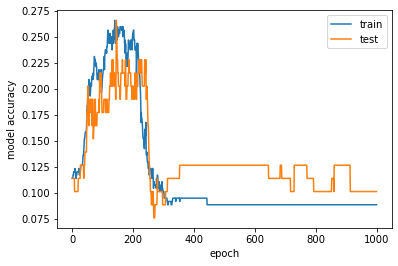

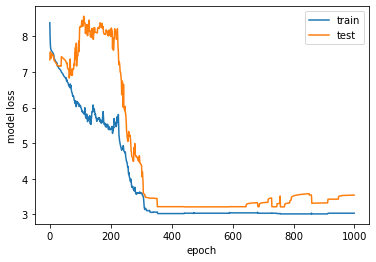

In [555]:

model = compile_model()
history=model.fit(X_train,Y_train, batch_size=8, epochs=1000, verbose=0,validation_data=(X_test,Y_test)) #10,64,12,7
#score1 = model.evaluate(X_train,Y_train,verbose=0)
score = model.evaluate(X_test,Y_test,verbose=0)


# print performance

#print('Train loss:', score1[0])
#print('Train accuracy:', score1[1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()




### The best test accuracy from various loss function:

"binary_crossentropy" (Ftrl, Adam): 3% <br>
"sparse_categorical_crossentropy" (Adamax): 18% <br>
"poisson"(Adam): 8.86% <br>
"kl_divergence" (Adamax): 2.5% <br> 
"mean_squared_error" (SGD, Adamax): 10%<br>
"mean_absolute_error" (Adagrad): 0%  <br>
"mean_absolute_percentage_error" (SGD): 13.9%  <br>
"mean_squared_logarithmic_error" (SGD): 5% <br>
"huber_loss" (Nadam): 7.5% <br>
"log_cosh" (Adam): 11.3% <br>
"hinge" (Adagrad): 2.5% <br>
"squared_hinge" (Ftrl):10.1% <br>
"categorical_hinge" (Nadam): 6.3% <br>

### The best regularization that I found is sparse_categorical_crossentropy with Adamax optimizer. The highest test accuracy is 27.5% that I found, but I am still not very satisfied with it.

### I was having just G1 and G2 to predict G3, however, the test accuracy that I obtain is nearly zero. So I add some other features. I keep batch size: 8, number of epochs:1000, and  activation function: 'relu' the same, and change the optimizers, and loss function in the meanwhile.

## Let's try Portuguese final student grades prediction

In [556]:
df,X,X_train,X_test,Y_train,Y_test = load_dataset(0.8,'por')

x_train shape: (519, 24)
x_test shape: (130, 24)
y_train shape: (519,)
y_test shape: (130,)


In [587]:
# create DNN regression
def model_DNN(act):
    model = Sequential()
    model.add(Dense(15,input_shape =(24,), activation=act))# input and 1st layer 
    model.add(Dense(25,activation=act)) #2nd layer 
    #model.add(Dense(25,activation=act)) #3rd layer
    model.add(Dense(22,activation=act)) #output layer 
    return model
def compile_model(optimizer='RMSprop'):#learning_rate =0.01
    model = model_DNN('relu')
    #model.compile(loss=l, optimizer=opt, metrics=['accuracy'])
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=['accuracy'])
    return model 

Test loss: 5.5943427085876465
Test accuracy: 0.0923076942563057


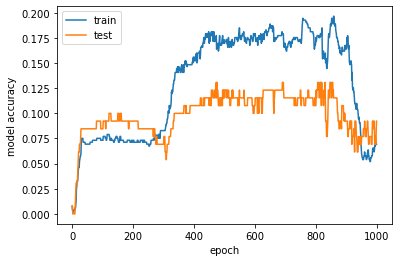

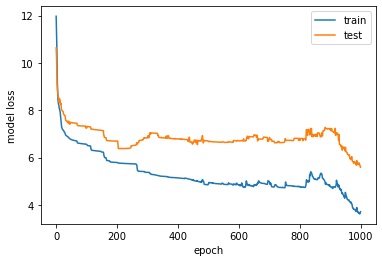

In [586]:

model = compile_model()
history=model.fit(X_train,Y_train, epochs=1000, verbose=0,validation_data=(X_test,Y_test))
score = model.evaluate(X_test,Y_test,verbose=0)


# print performance
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()



### The best test accuracy from various loss function:

"binary_crossentropy" (SGD): 2% <br>
"sparse_categorical_crossentropy" (Adamax): 10% <br>
"poisson"(Adam): 4.7% <br>
"kl_divergence" (RMSprop): 7.6% <br> 
"mean_squared_error" (Adam): 3%<br>
"mean_absolute_error" (Adadelta): 1.5%  <br>
"mean_absolute_percentage_error" (Ftrl): 7%  <br>
"mean_squared_logarithmic_error" (Adadelta): 3% <br>
"huber_loss" (Adam): 4.6% <br>
"log_cosh" (Adam):11.5 % <br>
"hinge" (Ftrl): 0.07% <br>
"squared_hinge" (Adadelta): 2.3% <br>
"categorical_hinge" (Adamax): 4.6% <br>

### The best regularization that I found is sparse_categorical_crossentropy with Adamax optimizer. The best test accuracy from the plot above is 12.5%

## math and Portuguese final student grades prediction

In [539]:
df,X,X_train,X_test,Y_train,Y_test = load_dataset(0.8,'mathandpor')

x_train shape: (835, 26)
x_test shape: (209, 26)
y_train shape: (835,)
y_test shape: (209,)


In [540]:
# create DNN regression
def model_DNN(act):
    model = Sequential()
    model.add(Dense(15,input_shape =(26,), activation=act))# input and 1st layer 
    model.add(Dense(25,activation=act)) #2nd layer 
    #model.add(Dense(25,activation=act)) #3rd layer
    model.add(Dense(22,activation=act)) #output layer 

    return model

def compile_model(optimizer='Adamax'):#learning_rate =0.01
    model = model_DNN('relu')
    #model.compile(loss=l, optimizer=opt, metrics=['accuracy'])
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=['accuracy'])
    return model 

Epoch 1/1000
27/27 [==============================] - 0s 6ms/step - loss: 8.4989 - accuracy: 0.0982 - val_loss: 8.1182 - val_accuracy: 0.0670
Epoch 2/1000
27/27 [==============================] - 0s 2ms/step - loss: 8.4154 - accuracy: 0.0994 - val_loss: 8.1315 - val_accuracy: 0.0670
Epoch 3/1000
27/27 [==============================] - 0s 2ms/step - loss: 8.3554 - accuracy: 0.1006 - val_loss: 8.0857 - val_accuracy: 0.0670
Epoch 4/1000
27/27 [==============================] - 0s 2ms/step - loss: 8.3110 - accuracy: 0.0994 - val_loss: 8.0160 - val_accuracy: 0.0670
Epoch 5/1000
27/27 [==============================] - 0s 2ms/step - loss: 8.3358 - accuracy: 0.0994 - val_loss: 7.9815 - val_accuracy: 0.0670
Epoch 6/1000
27/27 [==============================] - 0s 2ms/step - loss: 8.2899 - accuracy: 0.0994 - val_loss: 8.0020 - val_accuracy: 0.0670
Epoch 7/1000
27/27 [==============================] - 0s 2ms/step - loss: 8.2408 - accuracy: 0.0994 - val_loss: 8.1338 - val_accuracy: 0.0670
Epoch 

Epoch 115/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.7686 - accuracy: 0.1030 - val_loss: 8.0754 - val_accuracy: 0.0670
Epoch 116/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.7680 - accuracy: 0.1030 - val_loss: 8.0798 - val_accuracy: 0.0670
Epoch 117/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.7674 - accuracy: 0.1030 - val_loss: 8.0851 - val_accuracy: 0.0670
Epoch 118/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.7671 - accuracy: 0.1030 - val_loss: 8.0936 - val_accuracy: 0.0670
Epoch 119/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.7671 - accuracy: 0.1030 - val_loss: 8.1242 - val_accuracy: 0.0670
Epoch 120/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.7658 - accuracy: 0.1030 - val_loss: 8.0758 - val_accuracy: 0.0670
Epoch 121/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.7655 - accuracy: 0.1030 - val_loss: 8.1362 - val_accuracy:

Epoch 172/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.7366 - accuracy: 0.1018 - val_loss: 8.1011 - val_accuracy: 0.0670
Epoch 173/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.7360 - accuracy: 0.1018 - val_loss: 8.0573 - val_accuracy: 0.0670
Epoch 174/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.7357 - accuracy: 0.1018 - val_loss: 8.1107 - val_accuracy: 0.0670
Epoch 175/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.7353 - accuracy: 0.1018 - val_loss: 8.1003 - val_accuracy: 0.0670
Epoch 176/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.7344 - accuracy: 0.1018 - val_loss: 8.1083 - val_accuracy: 0.0670
Epoch 177/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.7334 - accuracy: 0.1018 - val_loss: 8.1563 - val_accuracy: 0.0670
Epoch 178/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.7328 - accuracy: 0.1018 - val_loss: 8.1538 - val_accuracy:

Epoch 229/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.6695 - accuracy: 0.1006 - val_loss: 8.0614 - val_accuracy: 0.0622
Epoch 230/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.6691 - accuracy: 0.0994 - val_loss: 8.0673 - val_accuracy: 0.0622
Epoch 231/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.6687 - accuracy: 0.0994 - val_loss: 8.0739 - val_accuracy: 0.0622
Epoch 232/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.6679 - accuracy: 0.1006 - val_loss: 8.0700 - val_accuracy: 0.0622
Epoch 233/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.6669 - accuracy: 0.0994 - val_loss: 8.1215 - val_accuracy: 0.0622
Epoch 234/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.6676 - accuracy: 0.0994 - val_loss: 8.0625 - val_accuracy: 0.0622
Epoch 235/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.6664 - accuracy: 0.1006 - val_loss: 8.1218 - val_accuracy:

27/27 [==============================] - 0s 2ms/step - loss: 7.5829 - accuracy: 0.0982 - val_loss: 8.0542 - val_accuracy: 0.0622
Epoch 342/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.5813 - accuracy: 0.0994 - val_loss: 8.0687 - val_accuracy: 0.0622
Epoch 343/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.5806 - accuracy: 0.0994 - val_loss: 8.1369 - val_accuracy: 0.0622
Epoch 344/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.5799 - accuracy: 0.0994 - val_loss: 8.1144 - val_accuracy: 0.0622
Epoch 345/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.5820 - accuracy: 0.0982 - val_loss: 8.1113 - val_accuracy: 0.0622
Epoch 346/1000
27/27 [==============================] - 0s 1ms/step - loss: 7.5793 - accuracy: 0.0994 - val_loss: 8.0561 - val_accuracy: 0.0622
Epoch 347/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.5782 - accuracy: 0.0994 - val_loss: 8.1150 - val_accuracy: 0.0622
Epoch 3

Epoch 398/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.5324 - accuracy: 0.0958 - val_loss: 8.0915 - val_accuracy: 0.0622
Epoch 399/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.5326 - accuracy: 0.0958 - val_loss: 8.0448 - val_accuracy: 0.0622
Epoch 400/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.5336 - accuracy: 0.0958 - val_loss: 8.0367 - val_accuracy: 0.0622
Epoch 401/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.5316 - accuracy: 0.0970 - val_loss: 8.0325 - val_accuracy: 0.0622
Epoch 402/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.5315 - accuracy: 0.0958 - val_loss: 8.0313 - val_accuracy: 0.0622
Epoch 403/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.5308 - accuracy: 0.0958 - val_loss: 8.0367 - val_accuracy: 0.0622
Epoch 404/1000
27/27 [==============================] - 0s 1ms/step - loss: 7.5302 - accuracy: 0.0958 - val_loss: 8.0942 - val_accuracy:

Epoch 455/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.4280 - accuracy: 0.0898 - val_loss: 7.9619 - val_accuracy: 0.0335
Epoch 456/1000
27/27 [==============================] - ETA: 0s - loss: 6.5262 - accuracy: 0.15 - 0s 2ms/step - loss: 7.4253 - accuracy: 0.0874 - val_loss: 7.9585 - val_accuracy: 0.0383
Epoch 457/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.4227 - accuracy: 0.0886 - val_loss: 7.9493 - val_accuracy: 0.0287
Epoch 458/1000
27/27 [==============================] - 0s 1ms/step - loss: 7.4214 - accuracy: 0.0862 - val_loss: 7.9443 - val_accuracy: 0.0287
Epoch 459/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.4207 - accuracy: 0.0886 - val_loss: 7.9425 - val_accuracy: 0.0335
Epoch 460/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.4188 - accuracy: 0.0886 - val_loss: 7.9421 - val_accuracy: 0.0287
Epoch 461/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.4180 - accuracy:

27/27 [==============================] - 0s 2ms/step - loss: 7.1298 - accuracy: 0.0192 - val_loss: 7.4943 - val_accuracy: 0.0191
Epoch 512/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.1293 - accuracy: 0.0192 - val_loss: 7.4983 - val_accuracy: 0.0239
Epoch 513/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.1289 - accuracy: 0.0204 - val_loss: 7.4999 - val_accuracy: 0.0191
Epoch 514/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.1288 - accuracy: 0.0180 - val_loss: 7.4901 - val_accuracy: 0.0239
Epoch 515/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.1282 - accuracy: 0.0180 - val_loss: 7.4933 - val_accuracy: 0.0239
Epoch 516/1000
27/27 [==============================] - 0s 1ms/step - loss: 7.1272 - accuracy: 0.0180 - val_loss: 7.4913 - val_accuracy: 0.0191
Epoch 517/1000
27/27 [==============================] - 0s 2ms/step - loss: 7.1273 - accuracy: 0.0180 - val_loss: 7.4954 - val_accuracy: 0.0191
Epoch 5

Epoch 568/1000
27/27 [==============================] - ETA: 0s - loss: 6.7747 - accuracy: 0.12 - 0s 2ms/step - loss: 6.8103 - accuracy: 0.1796 - val_loss: 7.4360 - val_accuracy: 0.1770
Epoch 569/1000
27/27 [==============================] - 0s 2ms/step - loss: 6.8059 - accuracy: 0.1796 - val_loss: 7.4439 - val_accuracy: 0.1818
Epoch 570/1000
27/27 [==============================] - 0s 2ms/step - loss: 6.8031 - accuracy: 0.1796 - val_loss: 7.5068 - val_accuracy: 0.1818
Epoch 571/1000
27/27 [==============================] - 0s 2ms/step - loss: 6.8012 - accuracy: 0.1784 - val_loss: 7.5045 - val_accuracy: 0.1818
Epoch 572/1000
27/27 [==============================] - 0s 2ms/step - loss: 6.7983 - accuracy: 0.1808 - val_loss: 7.4544 - val_accuracy: 0.1770
Epoch 573/1000
27/27 [==============================] - 0s 2ms/step - loss: 6.7968 - accuracy: 0.1808 - val_loss: 7.6209 - val_accuracy: 0.1818
Epoch 574/1000
27/27 [==============================] - 0s 2ms/step - loss: 6.7941 - accuracy:

Epoch 681/1000
27/27 [==============================] - 0s 2ms/step - loss: 6.0495 - accuracy: 0.1461 - val_loss: 5.3651 - val_accuracy: 0.1196
Epoch 682/1000
27/27 [==============================] - 0s 1ms/step - loss: 6.0265 - accuracy: 0.1449 - val_loss: 5.1049 - val_accuracy: 0.1148
Epoch 683/1000
27/27 [==============================] - 0s 2ms/step - loss: 6.0949 - accuracy: 0.1449 - val_loss: 5.1041 - val_accuracy: 0.1196
Epoch 684/1000
27/27 [==============================] - 0s 2ms/step - loss: 6.0457 - accuracy: 0.1449 - val_loss: 5.2241 - val_accuracy: 0.1196
Epoch 685/1000
27/27 [==============================] - 0s 2ms/step - loss: 6.0493 - accuracy: 0.1449 - val_loss: 5.2323 - val_accuracy: 0.1148
Epoch 686/1000
27/27 [==============================] - 0s 2ms/step - loss: 6.0014 - accuracy: 0.1449 - val_loss: 5.2122 - val_accuracy: 0.1196
Epoch 687/1000
27/27 [==============================] - 0s 2ms/step - loss: 5.9829 - accuracy: 0.1449 - val_loss: 5.2119 - val_accuracy:

Epoch 794/1000
27/27 [==============================] - 0s 2ms/step - loss: 5.6521 - accuracy: 0.1102 - val_loss: 4.7469 - val_accuracy: 0.1100
Epoch 795/1000
27/27 [==============================] - 0s 2ms/step - loss: 5.6386 - accuracy: 0.1090 - val_loss: 4.7743 - val_accuracy: 0.1100
Epoch 796/1000
27/27 [==============================] - 0s 2ms/step - loss: 5.6404 - accuracy: 0.1090 - val_loss: 4.7464 - val_accuracy: 0.1100
Epoch 797/1000
27/27 [==============================] - 0s 2ms/step - loss: 5.6544 - accuracy: 0.1078 - val_loss: 4.7487 - val_accuracy: 0.1100
Epoch 798/1000
27/27 [==============================] - 0s 2ms/step - loss: 5.6618 - accuracy: 0.1078 - val_loss: 4.7487 - val_accuracy: 0.1100
Epoch 799/1000
27/27 [==============================] - 0s 2ms/step - loss: 5.6464 - accuracy: 0.1078 - val_loss: 4.7473 - val_accuracy: 0.1100
Epoch 800/1000
27/27 [==============================] - 0s 2ms/step - loss: 5.6482 - accuracy: 0.1078 - val_loss: 4.7351 - val_accuracy:

Epoch 851/1000
27/27 [==============================] - 0s 1ms/step - loss: 5.4529 - accuracy: 0.0922 - val_loss: 4.8090 - val_accuracy: 0.0957
Epoch 852/1000
27/27 [==============================] - 0s 2ms/step - loss: 5.4816 - accuracy: 0.0910 - val_loss: 4.7675 - val_accuracy: 0.0957
Epoch 853/1000
27/27 [==============================] - 0s 2ms/step - loss: 5.4589 - accuracy: 0.0922 - val_loss: 4.7707 - val_accuracy: 0.1005
Epoch 854/1000
27/27 [==============================] - 0s 2ms/step - loss: 5.4769 - accuracy: 0.0898 - val_loss: 4.9725 - val_accuracy: 0.1005
Epoch 855/1000
27/27 [==============================] - 0s 2ms/step - loss: 5.5025 - accuracy: 0.0934 - val_loss: 5.0230 - val_accuracy: 0.1005
Epoch 856/1000
27/27 [==============================] - 0s 2ms/step - loss: 5.4830 - accuracy: 0.0910 - val_loss: 4.9657 - val_accuracy: 0.1005
Epoch 857/1000
27/27 [==============================] - 0s 2ms/step - loss: 5.4299 - accuracy: 0.0910 - val_loss: 4.8262 - val_accuracy:

Epoch 964/1000
27/27 [==============================] - 0s 2ms/step - loss: 3.0635 - accuracy: 0.0575 - val_loss: 3.0319 - val_accuracy: 0.0670
Epoch 965/1000
27/27 [==============================] - 0s 2ms/step - loss: 3.0427 - accuracy: 0.0575 - val_loss: 3.0319 - val_accuracy: 0.0670
Epoch 966/1000
27/27 [==============================] - 0s 2ms/step - loss: 3.0420 - accuracy: 0.0575 - val_loss: 3.0319 - val_accuracy: 0.0670
Epoch 967/1000
27/27 [==============================] - 0s 2ms/step - loss: 3.0510 - accuracy: 0.0575 - val_loss: 3.0319 - val_accuracy: 0.0670
Epoch 968/1000
27/27 [==============================] - 0s 2ms/step - loss: 3.0327 - accuracy: 0.0575 - val_loss: 3.0319 - val_accuracy: 0.0670
Epoch 969/1000
27/27 [==============================] - 0s 2ms/step - loss: 3.0326 - accuracy: 0.0575 - val_loss: 3.0319 - val_accuracy: 0.0670
Epoch 970/1000
27/27 [==============================] - 0s 2ms/step - loss: 3.0325 - accuracy: 0.0575 - val_loss: 3.0319 - val_accuracy:

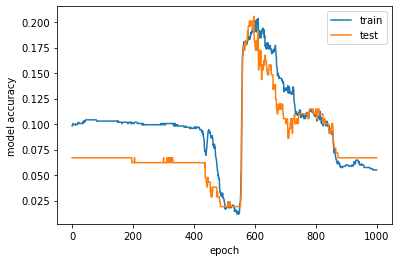

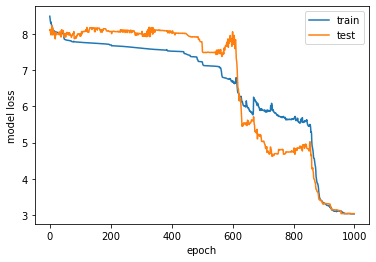

In [547]:

model = compile_model()
history=model.fit(X_train,Y_train, epochs=1000, verbose=1,validation_data=(X_test,Y_test))
score = model.evaluate(X_test,Y_test,verbose=1)


# print performance
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()



# Summary

### The best regularization that I found for all datasets are 'sparse_categorical_crossentropy' with Adamax optimizer that I found. I could be wrong for the best optimizer of loss function in (portuguese+math) dataset, since I did not use the GridSearchCV to test it. Also activation function does not have to be 'relu'.

### From the model accuracy of (portuguese+math) dataset the best test accuracy reached to 20%, which is better than Portuguese prediction. The best prediction is definitely for math student's final grade, which is 27.5%. However, it is still very worse prediction. With around 30% of accuracy, which is sort of guessing. I think either Deep Neural Network (DNN) is not a good model to predict student performance, or we need more information to predict student final grade (G3). For example, more features like student's grade of previous education, quality of teaching, intelligence quotient etc.

# Question 2: Architecture

# Part 2 a) and b)

I have learned some interesting way to distribute the number of neurons in all three layers from these websites: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw <br>
https://www.researchgate.net/post/How-to-decide-the-number-of-hidden-layers-and-nodes-in-a-hidden-layer<br>

Usually, one can prevent over-fitting by using equation below:

$$N_h = \frac{N_s}{(\alpha*(N_i+N_o)}$$
Where, <br> 
$N_h$ = number of hidden neurons <br>
$N_i$ = number of input neurons <br>
$N_o$ = number of output neurons <br>
$N_s$ = number of samples in training data set <br>
$\alpha$ = an arbitrary scaling factor usually 2-10 <br>

From the website it says:

1. The number of hidden neurons should be between the size of the input layer and the size of the output layer.
2. The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
3. The number of hidden neurons should be less than twice the size of the input layer.

So,
$$N_i+N_h+N_o = \text{total neurons}$$
$$\frac{2}{3}(N_i+N_o) = N_h$$
$$2N_i>N_h$$

Let play around with the neural network model:

In [724]:
df,X,X_train,X_test,Y_train,Y_test = load_dataset(0.8,'math')
df

x_train shape: (316, 23)
x_test shape: (79, 23)
y_train shape: (316,)
y_test shape: (79,)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,0,1,1,4,4,3,0,...,4,3,4,1,1,3,6,5,6,6
1,0,0,17,0,1,0,1,1,3,4,...,5,3,3,1,1,3,4,5,5,6
2,0,0,15,0,0,0,1,1,3,4,...,4,3,2,2,3,3,10,7,8,10
3,0,0,15,0,1,0,4,2,1,2,...,3,2,2,1,1,5,2,15,14,15
4,0,0,16,0,1,0,3,3,4,4,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,1,20,0,0,1,2,2,2,2,...,5,5,4,4,5,4,11,9,9,9
391,1,1,17,0,0,0,3,1,2,2,...,2,4,5,3,4,2,3,14,16,16
392,1,1,21,1,1,0,1,1,4,4,...,5,5,3,3,3,3,3,10,8,7
393,1,1,18,1,0,0,3,2,2,4,...,4,4,1,3,4,5,0,11,12,10


In [721]:

# create DNN regression
def model_DNN(act):
    model = Sequential()
    
    #total neurons: 1000 with 1 hidden layers, each layers contains 34  neurons
    model.add(Dense(250,input_shape =(23,), activation=act))# input and 1st layer
    model.add(Dense(200,activation=act)) #2nd layer
    model.add(Dense(100,activation=act)) #3rd layer
    model.add(Dense(100,activation=act)) #3rd layer
    model.add(Dense(350,activation=act)) #output

   
    '''
    #total neurons: 256, with 2 hidden layers, each layers contains 34  neurons
    model.add(Dense(64,input_shape =(23,), activation=act))# input and 1st layer
    model.add(Dense(52,activation=act)) #2nd layer
    model.add(Dense(50,activation=act)) #3rd layer
    model.add(Dense(90,activation=act)) #output
    
    #total neurons: 400, with 2 hidden layers, each layers contains 80  neurons
    model.add(Dense(100,input_shape =(23,), activation=act))# input and 1st layer
    model.add(Dense(90,activation=act)) #2nd layer
    model.add(Dense(70,activation=act)) #2nd layer
    model.add(Dense(140,activation=act)) #output
    
    #total neurons: 2000 with 1 hidden layers, each layers contains 34  neurons
    model.add(Dense(500,input_shape =(23,), activation=act))# input and 1st layer
    model.add(Dense(500,activation=act)) #2nd layer
    model.add(Dense(300,activation=act)) #3rd layer
    model.add(Dense(700,activation=act)) #output 
  
    '''
    return model

def compile_model(optimizer='Adamax'):#learning_rate =0.01
    model = model_DNN('relu')
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=['accuracy'])
    return model 



Test loss: 5.857933044433594
Test accuracy: 0.13924050331115723


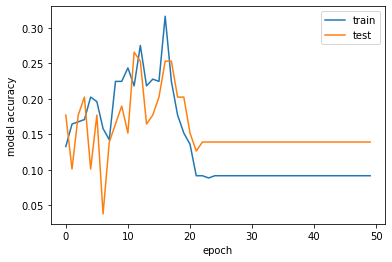

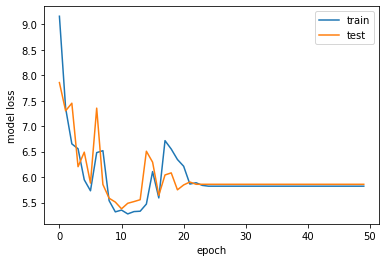

In [722]:

model = compile_model()
history=model.fit(X_train,Y_train, batch_size=8, epochs=50, verbose=0,validation_data=(X_test,Y_test)) #10,64,12,7
#score1 = model.evaluate(X_train,Y_train,verbose=0)
score = model.evaluate(X_test,Y_test,verbose=0)


# print performance

#print('Train loss:', score1[0])
#print('Train accuracy:', score1[1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()



x_train shape: (519, 24)
x_test shape: (130, 24)
y_train shape: (519,)
y_test shape: (130,)
Test loss: 6.441230297088623
Test accuracy: 0.13846154510974884


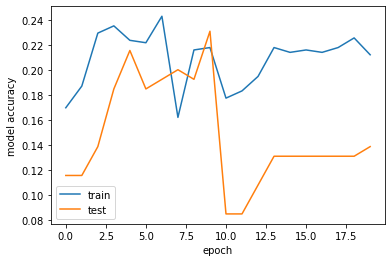

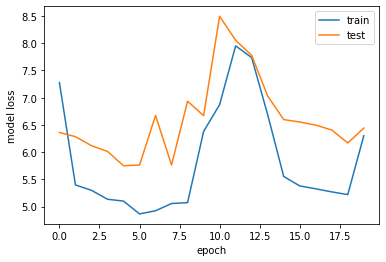

In [723]:
df,X,X_train,X_test,Y_train,Y_test = load_dataset(0.8,'por')
# create DNN regression
def model_DNN(act):
    model = Sequential()
    
    #total neurons: 1000 with 1 hidden layers, each layers contains 34  neurons
    model.add(Dense(250,input_shape =(24,), activation=act))# input and 1st layer
    model.add(Dense(200,activation=act)) #2nd layer
    model.add(Dense(100,activation=act)) #3rd layer
    model.add(Dense(100,activation=act)) #3rd layer
    model.add(Dense(350,activation=act)) #output
   
    '''
    #total neurons: 256, with 2 hidden layers, each layers contains 34  neurons
    model.add(Dense(64,input_shape =(23,), activation=act))# input and 1st layer
    model.add(Dense(52,activation=act)) #2nd layer
    model.add(Dense(50,activation=act)) #3rd layer
    model.add(Dense(90,activation=act)) #output
    
    #total neurons: 400, with 2 hidden layers, each layers contains 80  neurons
    model.add(Dense(100,input_shape =(23,), activation=act))# input and 1st layer
    model.add(Dense(90,activation=act)) #2nd layer
    model.add(Dense(70,activation=act)) #2nd layer
    model.add(Dense(140,activation=act)) #output
    
    #total neurons: 2000 with 1 hidden layers, each layers contains 34  neurons
    model.add(Dense(500,input_shape =(23,), activation=act))# input and 1st layer
    model.add(Dense(500,activation=act)) #2nd layer
    model.add(Dense(300,activation=act)) #3rd layer
    model.add(Dense(700,activation=act)) #output 
  
    '''
    return model

def compile_model(optimizer='Adamax'):#learning_rate =0.01
    model = model_DNN('relu')
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=['accuracy'])
    return model 


model = compile_model()
history=model.fit(X_train,Y_train, batch_size=8, epochs=20, verbose=0,validation_data=(X_test,Y_test)) #10,64,12,7
#score1 = model.evaluate(X_train,Y_train,verbose=0)
score = model.evaluate(X_test,Y_test,verbose=0)


# print performance

#print('Train loss:', score1[0])
#print('Train accuracy:', score1[1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()




x_train shape: (835, 26)
x_test shape: (209, 26)
y_train shape: (835,)
y_test shape: (209,)
Test loss: 6.971185207366943
Test accuracy: 0.13875597715377808


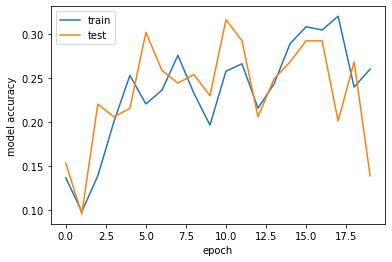

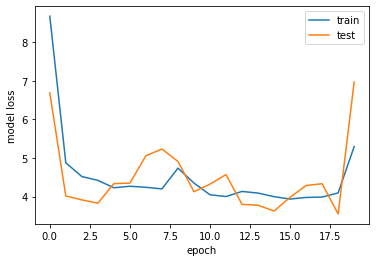

In [717]:
df,X,X_train,X_test,Y_train,Y_test = load_dataset(0.8,'mathandpor')
# create DNN regression
def model_DNN(act):
    model = Sequential()

    #total neurons: 1000 with 1 hidden layers, each layers contains 34  neurons
    model.add(Dense(250,input_shape =(26,), activation=act))# input and 1st layer
    model.add(Dense(200,activation=act)) #2nd layer
    model.add(Dense(100,activation=act)) #3rd layer
    model.add(Dense(100,activation=act)) #3rd layer
    model.add(Dense(350,activation=act)) #output

   
    '''
    #total neurons: 256, with 2 hidden layers, each layers contains 34  neurons
    model.add(Dense(64,input_shape =(23,), activation=act))# input and 1st layer
    model.add(Dense(52,activation=act)) #2nd layer
    model.add(Dense(50,activation=act)) #3rd layer
    model.add(Dense(90,activation=act)) #output
    
    #total neurons: 400, with 2 hidden layers, each layers contains 80  neurons
    model.add(Dense(100,input_shape =(23,), activation=act))# input and 1st layer
    model.add(Dense(90,activation=act)) #2nd layer
    model.add(Dense(70,activation=act)) #2nd layer
    model.add(Dense(140,activation=act)) #output
    
    #total neurons: 2000 with 1 hidden layers, each layers contains 34  neurons
    model.add(Dense(500,input_shape =(23,), activation=act))# input and 1st layer
    model.add(Dense(500,activation=act)) #2nd layer
    model.add(Dense(300,activation=act)) #3rd layer
    model.add(Dense(700,activation=act)) #output 
  
    '''
    return model

def compile_model(optimizer='Adamax'):#learning_rate =0.01
    model = model_DNN('relu')
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=['accuracy'])
    return model 


model = compile_model()
history=model.fit(X_train,Y_train, batch_size=8, epochs=20, verbose=0,validation_data=(X_test,Y_test)) #10,64,12,7
#score1 = model.evaluate(X_train,Y_train,verbose=0)
score = model.evaluate(X_test,Y_test,verbose=0)


# print performance

#print('Train loss:', score1[0])
#print('Train accuracy:', score1[1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()




### In the end, I pick 1000 of neurons (N). I was having four neural layers (1 input, 2 hidden and 1 output). The best test accuracy reach to 40% (around 30-40%) for math final grade. Originally, I am thinking 2 hidden layers should be good enough (It is not a very complex dataset). Then I wonder, why can't I have 1 more hidden layer. So, I add one more hidden layer, an interesting happened. The best test accuracy is still around 30-40%, which is still better than my prediction in question. However, the number of epoches require to reach the highest accuracy become lower. Originally, it takes around 400 epoches to reach highest accuracy, but now it needs 20 epcohes only.

ADR: 10/10 -- nice to try lots of stuff

# Reference:

P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.